In [1]:
from zipline import run_algorithm
import matplotlib.pyplot as plt
import math
from zipline.api import (order_target_percent,symbol,set_commission,set_benchmark,order,record, get_open_orders)
import numpy as np
from zipline.finance.commission import PerTrade
import pandas as pd
from zipline.api import order_target, record, symbol, set_commission, set_slippage, set_long_only,order_target_percent, order, schedule_function,  date_rules,time_rules
from zipline.finance import commission
import warnings
import matplotlib.pyplot as plt
from zipline.utils.calendar_utils import get_calendar
# import talib
# from talib import MACD # type: ignore
warnings.filterwarnings('ignore')
warnings.filterwarnings('always')
import sys
import os
root_dir = os.getcwd().replace('/Notebooks','')
sys.path.insert(1, root_dir)
from zipline.utils.run_algo import load_extensions
#from utils.utils import *
from logbook import (NestedSetup, NullHandler, Logger, StreamHandler, StderrHandler, INFO, WARNING, DEBUG, ERROR)
import pytz
load_extensions(
    default=True,
    extensions=[],
    strict=True,
    environ=os.environ,
)
%matplotlib inline
import matplotlib.pyplot as plt
import quantstats as qs
import yfinance as yf
from zipline.data import bundles

/home/popeye/.local/lib/python3.10/site-packages/quantstats/utils.py:300: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic("matplotlib inline")


In [2]:
calendar_name = 'XNYS'
calendar = get_calendar(calendar_name)

In [6]:
bundle= 'spStocks'
bundle_data = bundles.load(bundle)

In [10]:
sids = bundle_data.asset_finder.sids
print(sids)

(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97)


[*********************100%%**********************]  1 of 1 completed


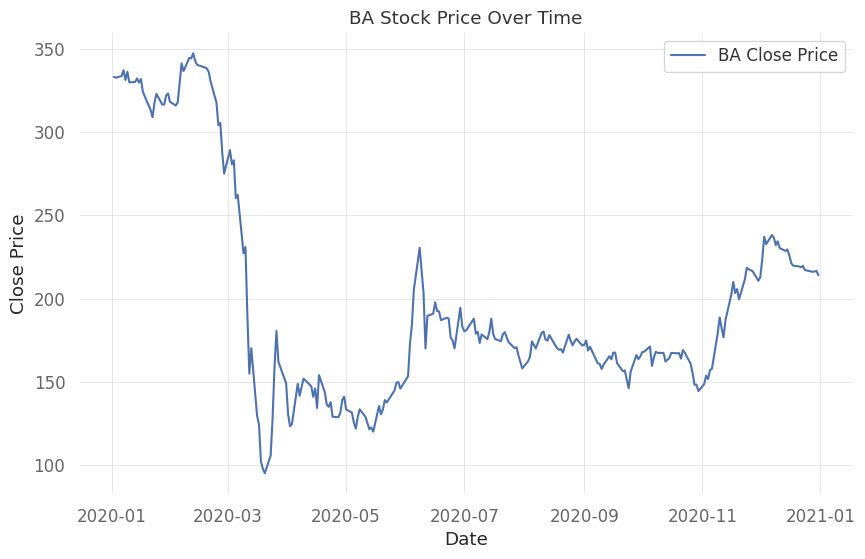

In [127]:
symbol = "BA"
stock_data = yf.download(symbol, start="2020-01-01", end="2021-01-01")

price_data = stock_data['Close']

plt.figure(figsize=(10, 6))
plt.plot(price_data, label=f'{symbol} Close Price')
plt.title(f'{symbol} Stock Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()



In [123]:
ast = bundle_data.asset_finder.retrieve_all(sids)
ast[50:52]

[Equity(50 [AZO]), Equity(51 [BA])]

In [15]:
def RSI(df, window):
    df['gain'] = (df['close'] - df['open']).apply(lambda x: x if x > 0 else 0)
    df['loss'] = (df['close'] - df['open']).apply(lambda x: -x if x < 0  else 0)

    df['ema_gain'] = df['gain'].rolling(window).mean()
    df['ema_loss'] = df['loss'].rolling(window).mean()

    df['rs'] = df['ema_gain'] / df['ema_loss']
    df['rsi'] = 100 - (100 / (1+ df['rs']))
    
    return df

In [133]:
capital_base = 10000
window = 30

def initialize(context):
    context.i = 0
    sids = bundle_data.asset_finder.sids
    ast = bundle_data.asset_finder.retrieve_all(sids)
    context.assets = ast[50:52]

def handle_data(context, data):
    context.i += 1

    if context.i < window + 1:
        return 
    
    for asset in context.assets:
        prices = data.history(asset, ['open', 'close', 'price'], bar_count= 30, frequency = '1d' )

        rsi_value = RSI(prices, 14).rsi[-1]
        
        
        if data.can_trade(asset) and not get_open_orders(asset):
            cash = context.portfolio.cash
            price = data.current(asset, 'price')

            if rsi_value > 70:
                order_target_percent(asset, -10, stop_price=(price*0.69))
            elif rsi_value < 30:
                order_target_percent(asset, 10, stop_price=(price * 0.90))
            else:
                order_target(asset, 0)
            
        record(closing_price = data.current(asset, 'close'),
               rsi = rsi_value)

In [134]:
start_date = pd.to_datetime('2019-01-01 00:00:00.0000', format='%Y-%m-%d %H:%M:%S.%f')
end_date = pd.to_datetime('2021-01-01 00:00:00.0000', format='%Y-%m-%d %H:%M:%S.%f')
results = run_algorithm(
    start=start_date,
    end=end_date,
    initialize=initialize,
    handle_data=handle_data,
    capital_base=10000,
    trading_calendar=calendar,
    bundle='spStocks',
    data_frequency='daily',
)

/home/popeye/.local/lib/python3.10/site-packages/zipline/finance/ledger.py:424: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self.daily_returns_series[session_ix] = self.todays_returns
/home/popeye/.local/lib/python3.10/site-packages/zipline/finance/ledger.py:424: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self.daily_returns_series[session_ix] = self.todays_returns
/home/popeye/.local/lib/python3.10/site-packages/empyrical/stats.py:710: RuntimeWarning: invalid value encountered in divide
  np.divide(
/home/popeye/.local/lib/python3.10/site-packages/empyrical/stats.py:799: RuntimeWarning: invalid value e

In [135]:
results.index = pd.to_datetime(results.index).tz_convert(None)

start = results.index[0]
end = results.index[-1]
benchmark = yf.download("BA", start=start, end=end)["Adj Close"].pct_change()
qs.reports.full(results.returns,benchmark= benchmark)

[*********************100%%**********************]  1 of 1 completed


/home/popeye/.local/lib/python3.10/site-packages/quantstats/utils.py:269: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  .pct_change()


/home/popeye/.local/lib/python3.10/site-packages/quantstats/reports.py:933: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  _stats.expected_return(df, compounded=compounded, prepare_returns=False) * pct
/home/popeye/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/home/popeye/.local/lib/python3.10/site-packages/quantstats/reports.py:936: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  _stats.expected_return(df, compounded=compounded, aggregate="M", prepare_returns=False) * pct
/home/popeye/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86:

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2020-02-28   2020-02-28
End Period                 2020-12-31   2020-12-31
Risk-Free Rate             0.0%         0.0%
Time in Market             22.0%        100.0%

Cumulative Return          -22.19%      2,535.25%
CAGR﹪                     -18.61%      1366.48%

Sharpe                     -0.36        1.17
Prob. Sharpe Ratio         36.14%       98.71%
Smart Sharpe               -0.35        1.13
Sortino                    -0.42        14.75
Smart Sortino              -0.41        14.31
Sortino/√2                 -0.3         10.43
Smart Sortino/√2           -0.29        10.12
Omega                      4.36         4.36

Max Drawdown               -47.58%      -347.4%
Longest DD Days            305          177
Volatility (ann.)          46.83%       4452.44%
R^2                        0.0          0.0
Information Ratio          0.07         0.07
Calmar   

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2020-03-02,2020-03-11,2020-03-17,15,-347.397906,-307.042434
2,2020-03-27,2020-05-15,2020-06-03,69,-64.766328,-63.161878
3,2020-06-09,2020-10-30,2020-12-02,177,-60.032095,-57.417761
4,2020-03-20,2020-03-20,2020-03-20,1,-18.667593,NaN
5,2020-12-08,2020-12-31,2020-12-31,24,-15.955271,-14.611878


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


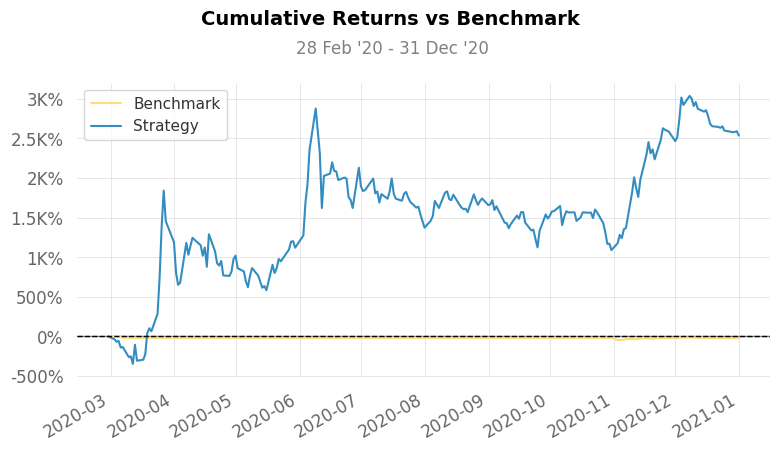

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


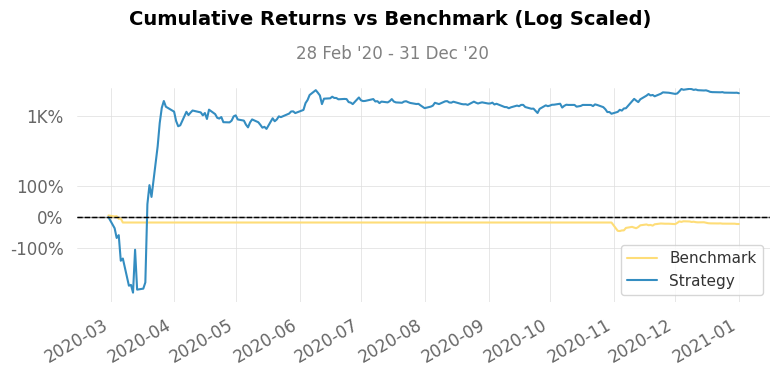

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


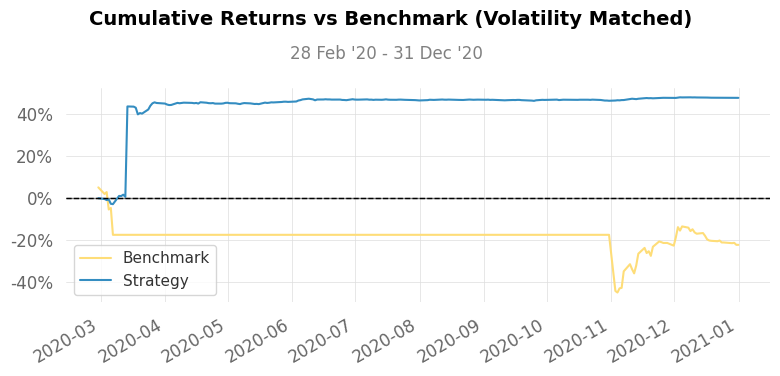

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


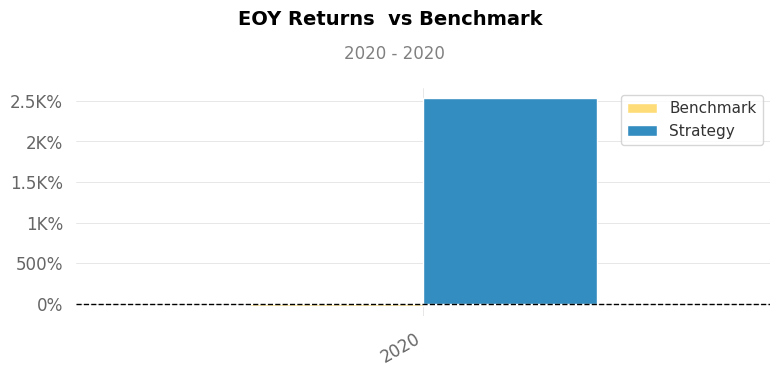

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


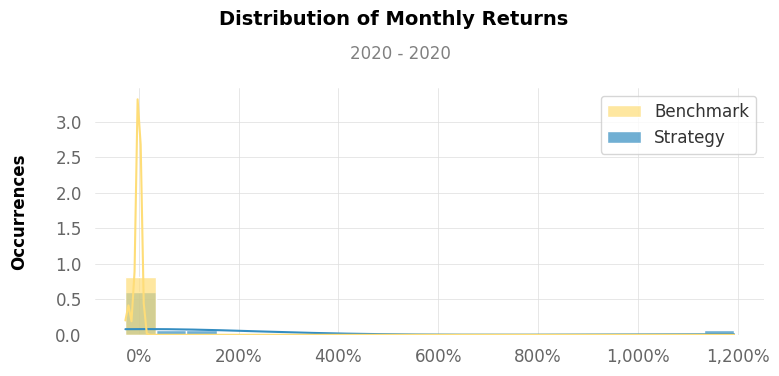

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


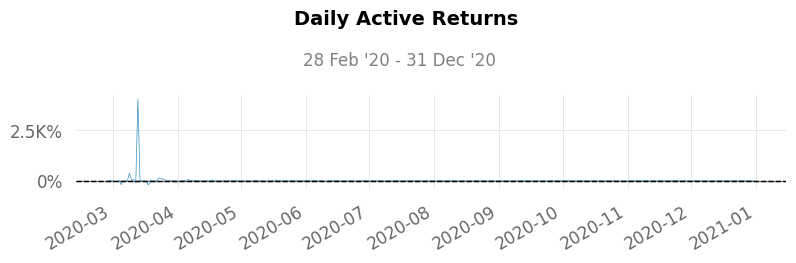

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


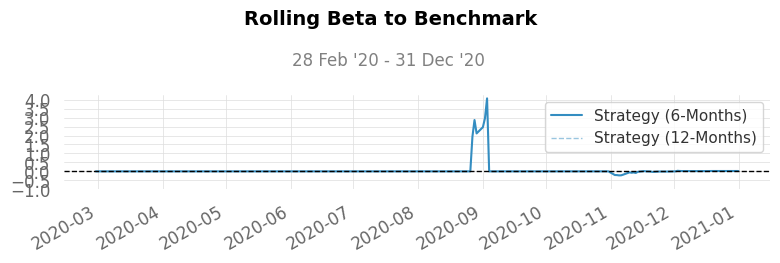

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


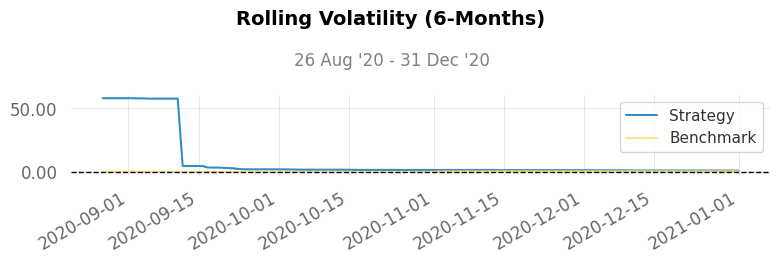

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


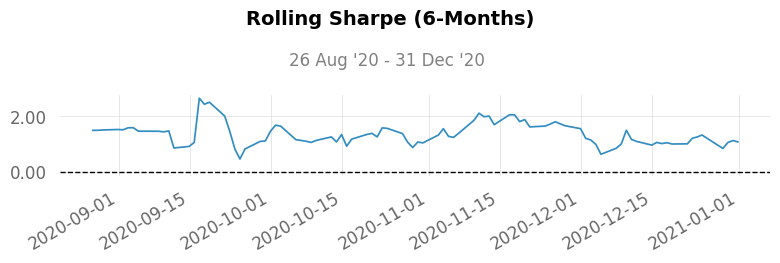

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


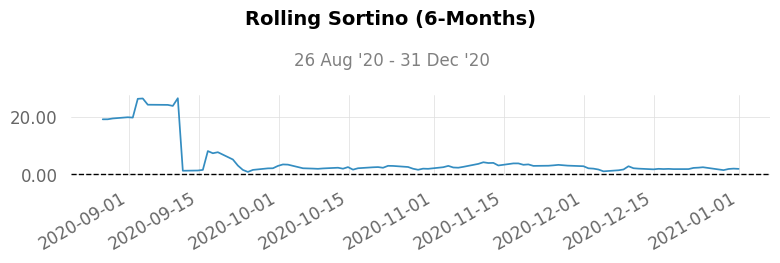

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


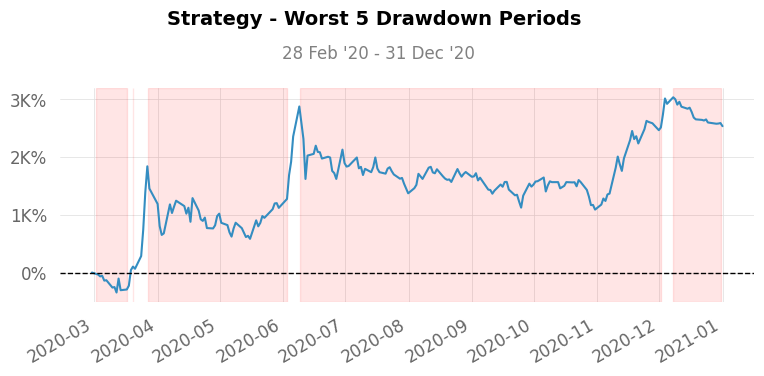

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


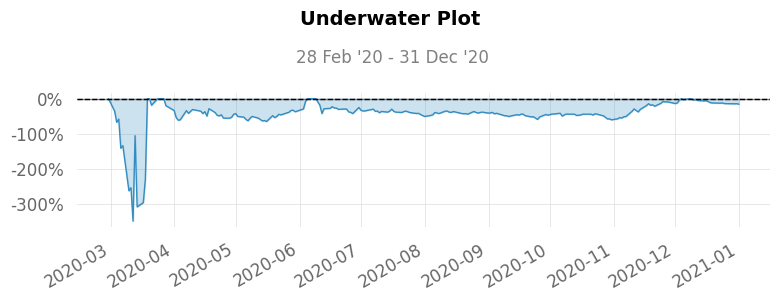

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


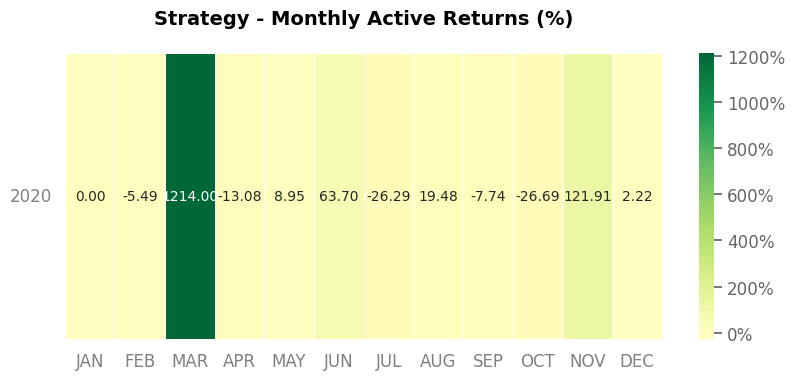

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


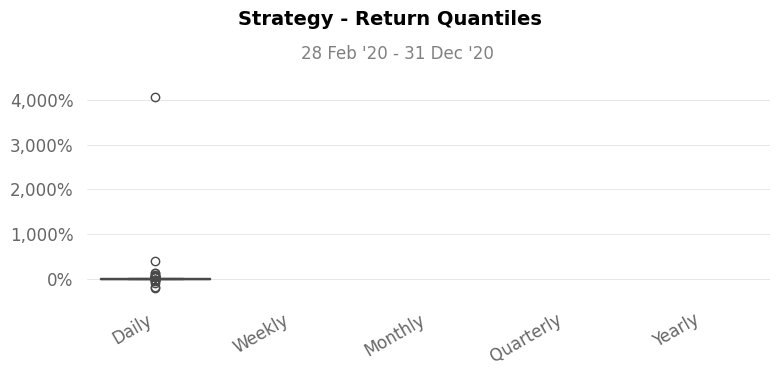

In [21]:
from zipline.api import order_target_percent, record, symbol
import pandas as pd
import numpy as np

def initialize(context):
    context.asset = symbol('BA')
    context.lookback_period = 14  # RSI lookback period
    context.lower_rsi_threshold = 30
    context.upper_rsi_threshold = 70

def handle_data(context, data):
    prices = data.history(context.asset, 'price', bar_count=context.lookback_period, frequency='1d')

    if len(prices) < context.lookback_period:
        return

    # Calculate RSI
    price_changes = prices.diff(1)
    gains = np.where(price_changes > 0, price_changes, 0).sum()
    losses = -np.where(price_changes < 0, price_changes, 0).sum()

    avg_gain = np.mean(gains)
    avg_loss = np.mean(losses)

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    # Make trading decisions based on RSI
    if data.can_trade(context.asset) and not get_open_orders(context.asset):
            cash = context.portfolio.cash
            price = data.current(context.asset, 'price')

            if rsi > 70:
                order_target_percent(context.asset, -10, stop_price=(price*0.69))
            elif rsi < 30:
                order_target_percent(context.asset, 10, stop_price=(price * 0.90))
            else:
                order_target(context.asset, 0)
    # Record data for analysis
    record(price=data.current(context.asset, 'price'), rsi=rsi)

In [22]:
start_date = pd.to_datetime('2019-01-01 00:00:00.0000', format='%Y-%m-%d %H:%M:%S.%f')
end_date = pd.to_datetime('2021-01-01 00:00:00.0000', format='%Y-%m-%d %H:%M:%S.%f')
results = run_algorithm(
    start=start_date,
    end=end_date,
    initialize=initialize,
    handle_data=handle_data,
    capital_base=10000,
    trading_calendar=calendar,
    bundle='spStocks',
    data_frequency='daily',
)

/home/popeye/.local/lib/python3.10/site-packages/zipline/data/data_portal.py:951: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="ffill", inplace=True)
/home/popeye/.local/lib/python3.10/site-packages/zipline/finance/ledger.py:424: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self.daily_returns_series[session_ix] = self.todays_returns
/home/popeye/.local/lib/python3.10/site-packages/zipline/data/data_portal.py:951: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="ffill", inplace=True)
/home/popeye/.local/lib/python3.10/site-packages/zipline/finance/ledger.py:424: FutureWarning: Series

[*********************100%%**********************]  1 of 1 completed

/home/popeye/.local/lib/python3.10/site-packages/quantstats/utils.py:269: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  .pct_change()


/home/popeye/.local/lib/python3.10/site-packages/quantstats/reports.py:933: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  _stats.expected_return(df, compounded=compounded, prepare_returns=False) * pct
/home/popeye/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/home/popeye/.local/lib/python3.10/site-packages/quantstats/reports.py:936: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  _stats.expected_return(df, compounded=compounded, aggregate="M", prepare_returns=False) * pct
/home/popeye/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86:

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2020-03-09   2020-03-09
End Period                 2020-12-31   2020-12-31
Risk-Free Rate             0.0%         0.0%
Time in Market             19.0%        21.0%

Cumulative Return          -5.77%       151.25%
CAGR﹪                     -4.92%       118.51%

Sharpe                     0.09         2.15
Prob. Sharpe Ratio         53.24%       99.8%
Smart Sharpe               0.07         1.7
Sortino                    0.11         7.08
Smart Sortino              0.09         5.6
Sortino/√2                 0.08         5.01
Smart Sortino/√2           0.06         3.96
Omega                      2.72         2.72

Max Drawdown               -33.25%      -17.24%
Longest DD Days            30           24
Volatility (ann.)          43.76%       59.38%
R^2                        0.0          0.0
Information Ratio          0.11         0.11
Calmar                 

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2020-03-10,2020-03-13,2020-03-17,8,-405.601912,-327.627460
2,2020-03-23,2020-12-07,2020-12-31,284,-211.500864,-210.225143


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


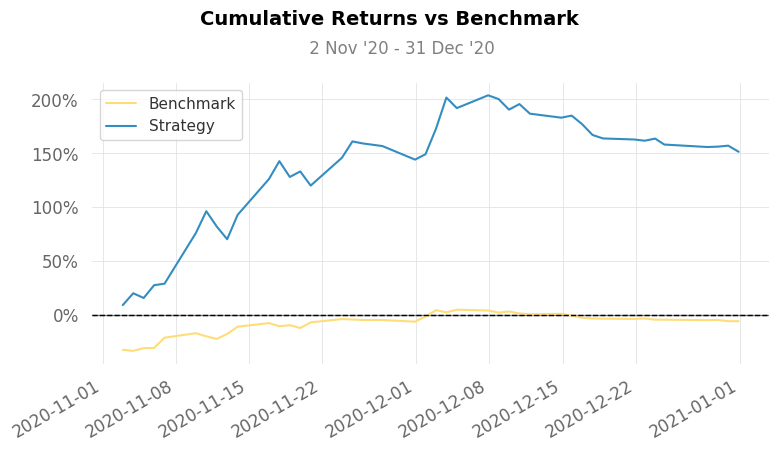

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


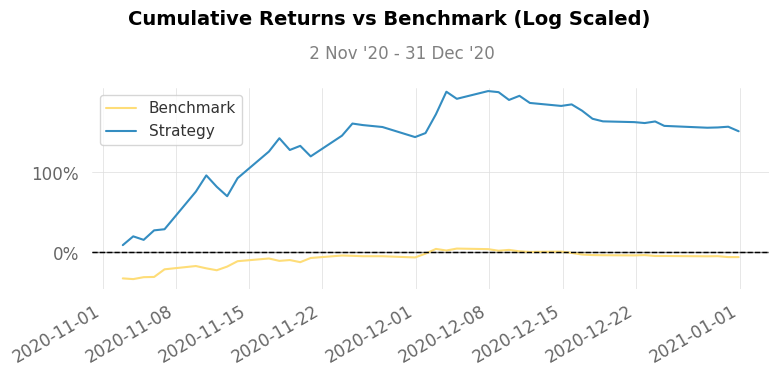

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


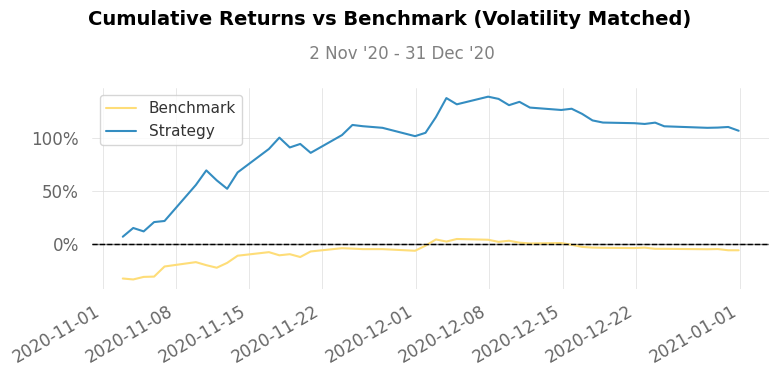

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


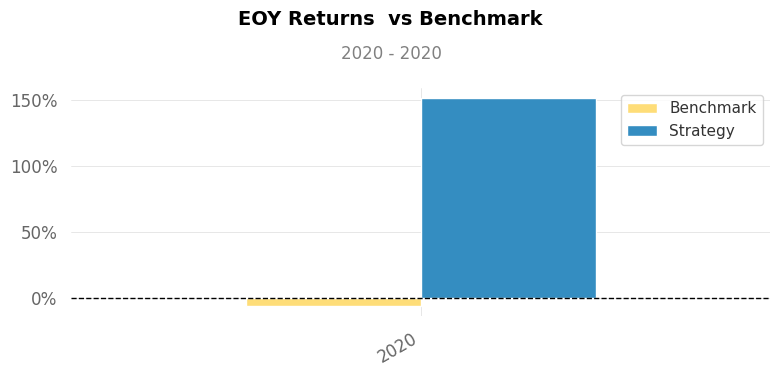

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


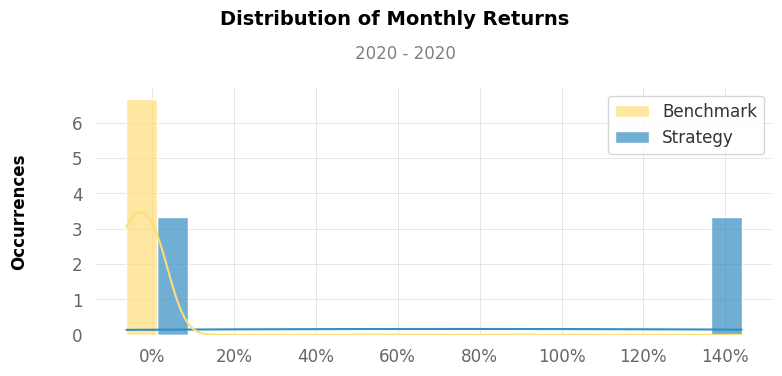

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


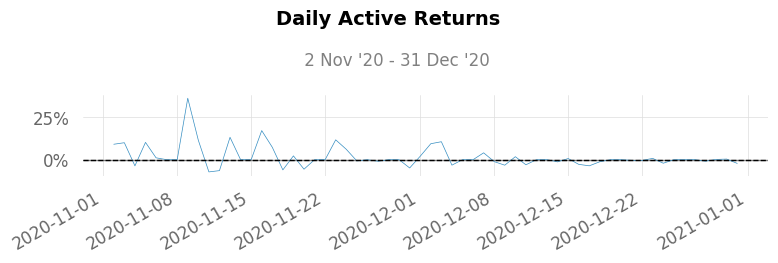

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


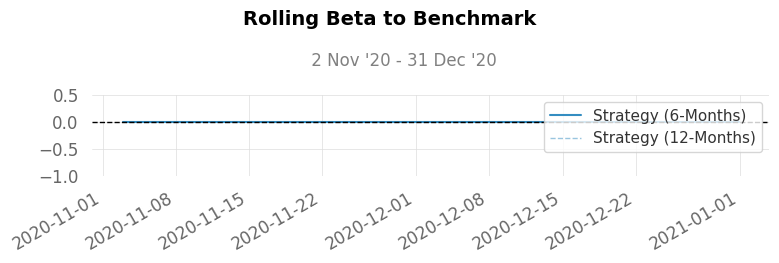

IndexError: index 0 is out of bounds for axis 0 with size 0

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


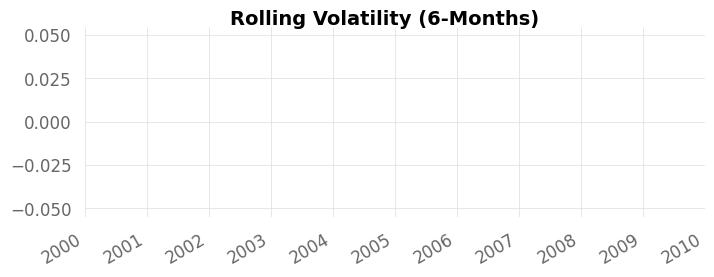

In [23]:
results.index = pd.to_datetime(results.index).tz_convert(None)

start = results.index[0]
end = results.index[-1]
benchmark = yf.download("BA", start=start, end=end)["Adj Close"].pct_change()
qs.reports.full(results.returns,benchmark= benchmark)